In [1]:
import time
import numpy as np
import pandas as pd

In [2]:
import lsst.sims.skybrightness as sb
from lsst.sims.utils import Site
import ephem
from obscond import SkyCalculations as sm

In [3]:
from opsimsummary import SynOpSim

Some imports failed, which implies some dependencies are missing as described below
No module named 'mpl_toolkits.basemap'
Visulization functions based on maps will not work


In [4]:
from obscond.observingPotential import ObservationPotential

In [5]:
from lsst.sims.utils import angularSeparation

In [6]:
from scipy.interpolate import interp1d

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')

In [8]:
import obscond

In [9]:
print(obscond.__version__)

0.5.1dev3


## DC2 DDF design

In [10]:
# uDDF center Design DC2 Run1 Note
rauDDF = np.radians(53.125)
decuDDF =  np.radians(-28.100)

## Example For Block 2 : 

These are the observations we want for the block of 7 to 10 years

In [11]:
op = ObservationPotential(rauDDF, decuDDF)

In [12]:
# 60 sec intervals of mjd values between 7 and 10 years 
t0 = 59580 + 7 * 365 
sec = 1.0 / 24.0 /60. /60.
hr = 60. * 60. * sec
t2 = np.arange(t0, t0 + 365 *3, 60 * sec)

In [13]:
opdf = op.potential_obscond(t2, fieldRA=rauDDF, fieldDec=decuDDF)

In [14]:
len(opdf)/ np.pi /1.0e7

0.05019113468444874

In [15]:
opdf.head()

,mjd,alt,az,sunAlt,moonRA,moonDec,moonAlt,night,moonDist
0,62135.000000,50.539905,313.845214,-1.936863,77.162288,25.866353,16.955501,2555,97.299443
1,62135.000694,50.383315,313.537720,-2.067200,77.169862,25.867593,17.102845,2555,97.306363
2,62135.001389,50.225927,313.232245,-2.200801,77.177425,25.868828,17.249769,2555,97.313271
3,62135.002083,50.067750,312.928776,-2.340170,77.184975,25.870058,17.396272,2555,97.320168
4,62135.002778,49.908795,312.627297,-2.489150,77.192513,25.871284,17.542347,2555,97.327053


In [16]:
# new
constraints = 'alt > 30 and alt < 85 and sunAlt < -12 and moonDist > 30'
availabletimes = op.available_times(opdf, constraints=constraints)

In [17]:
#new
len(availabletimes)

172579

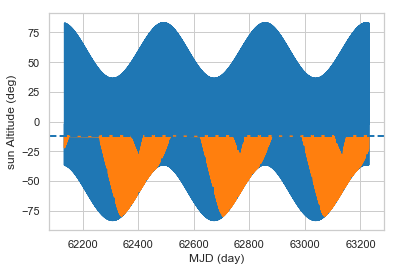

In [18]:
# new
fig, ax = plt.subplots()
#ax0, ax1 = ax
#dff = opdf.query('alt < 85. and alt > 20.')
ax.plot(opdf.mjd, opdf.sunAlt, label='sun Alt')
ax.plot(availabletimes.mjd, availabletimes.sunAlt, label='field constraints')
ax.axhline(-12.0, ls='dashed', lw=2)
ax.set_xlabel('MJD (day)')
ax.set_ylabel('sun Altitude (deg)')
fig.savefig('availabletimes_block2.png')

## Baseline Expectations

In [19]:
synopsim = SynOpSim.fromOpSimDB('/Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db',
                                 subset='ddf', opsimversion='lsstv3')

 reading from database sqlite:////Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db
Not doing all observations here 
56 ddf
SELECT * FROM Summary WHERE propID in (56)
We have filterNull set to False
checking that summary table read in

Reading in raw tables successful
replacing names works
dropping duplicates works
joining dithers works
Keeping units for lsstv3 from radians
check that the format matches the expectation


In [20]:
all_baseline_visits = synopsim.pointings.query('fieldID == 1427')

## Block 2

In [21]:
baseline_block2 = synopsim.pointings.query('fieldID == 1427 and night > 365*7')

In [22]:
unights = baseline_block2.query('filter == "u"').night.unique()

In [23]:
baseline_nights_2 = baseline_block2.query('filter != "u"').night.unique()

In [24]:
print('Number of nights using grizy filters is {}'.format(baseline_nights_2.size))

Number of nights using grizy filters is 61


In [25]:
ratio_sampling  = 0.5 # See DC2 design note (0.75)
required_nights = np.ceil(baseline_nights_2.size / ratio_sampling).astype(np.int)

In [26]:
print('Given the requirement of the cadence being {0}, the number of nights is {1}'.format(ratio_sampling, required_nights))

Given the requirement of the cadence being 0.5, the number of nights is 122


In [27]:
times = availabletimes.query('night in @baseline_nights_2').groupby('night').agg(dict(mjd=ObservationPotential.timerange)).rename(columns=dict(mjd='time'))

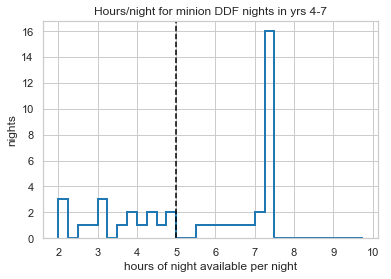

In [28]:
fig, ax = plt.subplots()
_ = times.time.hist(bins=np.arange(2., 10, 0.25), histtype='step',
                    lw=2, ax=ax)
ax.axvline(5.0, color='k', ls='dashed')
ax.set_ylabel('nights')
ax.set_xlabel('hours of night available per night')
ax.set_title('Hours/night for minion DDF nights in yrs 4-7')
fig.savefig('block_2_hours_pernight.png')

## Choosing nights

In [29]:
len(availabletimes)

172579

##  We want to select nights longer than 5 hours

In [30]:
shortnight = availabletimes.groupby('night').agg(dict(mjd=ObservationPotential.timerange))
shortnights = shortnight.query('mjd < 5').index.unique()
print(len(shortnights))

351


In [31]:
unights = baseline_block2.query('filter == "u"').night.unique()

In [32]:
target_nights = availabletimes.query('night not in @shortnights').query('night not in @unights').night.unique()

In [33]:
rng = np.random.RandomState(1)
target_nights.sort()
chosen_nights = rng.choice(target_nights, replace=False, size=required_nights)
chosen_nights.sort()

In [34]:
nstats = op.nightStats(availabletimes)
st_times = op.start_times(nstats, chosen_nights, rng)

In [35]:
dc2_visits_block2 = op.dc2_visits(st_times, year_block=2, pointings=all_baseline_visits)

In [36]:
dc2_visits_block2.groupby('filter').agg(dict(expMJD='count'))

,expMJD
filter,
g,610
i,1220
r,1220
y,1220
z,1586


/Users/rbiswas/soft/lsst_stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/rbiswas/soft/lsst_stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


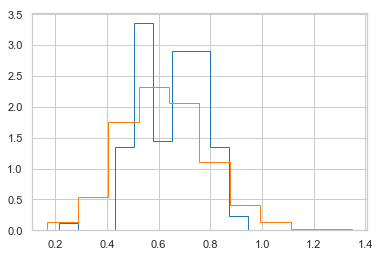

In [37]:
fig, ax = plt.subplots()
dc2_visits_block2.rawSeeing.hist(ax=ax,**dict(histtype='step', normed=1))
all_baseline_visits.rawSeeing.hist(ax=ax, **dict(histtype='step', normed=1))

In [38]:
dc2_visits_block2.to_csv('dc2_blocks.csv', index=False)

# Block 1 : 

In [39]:
# 60 sec intervals of mjd values between 7 and 10 years 
t0 = 59580 + 4 * 365 
sec = 1.0 / 24.0 /60. /60.
hr = 60. * 60. * sec
t01 = np.arange(t0, t0 + 365 *3, 60 * sec)

In [40]:
opdf = op.potential_obscond(t01, fieldRA=rauDDF, fieldDec=decuDDF)

In [41]:
# new
constraints_1 = 'alt > 30 and alt < 85 and sunAlt < -12 and moonDist > 30'
availabletimes_1 = op.available_times(opdf, constraints=constraints)

In [42]:
(availabletimes_1.mjd.min() - 59580)/365

4.000093226788736

In [48]:
shortnight_1 = availabletimes_1.groupby('night').agg(dict(mjd=ObservationPotential.timerange))
shortnights_1 = shortnight_1.query('mjd < 5').index.unique()
print(len(shortnights_1))

347


In [43]:
baseline_block1 = synopsim.pointings.query('fieldID == 1427 and night < 365*7 and night > 365*4')

In [44]:
unights_1 = baseline_block1.query('filter == "u"').night.unique()

In [50]:
target_nights_1 = availabletimes_1.query('night not in @shortnights_1').query('night not in @unights_1').night.unique()

In [51]:
baseline_nights_1 = baseline_block1.query('filter != "u"').night.unique()

In [52]:
ratio_sampling_1  = 0.75 # See DC2 design note (0.75)
required_nights_1 = np.ceil(baseline_nights_1.size / ratio_sampling).astype(np.int)

In [53]:
required_nights_1

114

In [54]:
rng = np.random.RandomState(1)
target_nights_1.sort()
chosen_nights_1 = rng.choice(target_nights_1, replace=False, size=required_nights_1)
chosen_nights_1.sort()

In [55]:
nstats_1 = op.nightStats(availabletimes_1)
st_times_1 = op.start_times(nstats_1, chosen_nights_1, rng)

In [67]:
dc2_visits_block1 = op.dc2_visits(st_times_1, year_block=1, pointings=baseline_block1)

In [69]:
dc2_visits_block1.groupby('filter').agg(dict(expMJD='count'))

,expMJD
filter,
g,912
i,1710
r,1710
y,1710
z,2280


In [70]:
dc2_visits_block1.to_csv('dc2_block1.csv', index=False)

In [59]:
len(dc2_visits_block1)

8322

In [60]:
len(dc2_visits_block2)

5856

In [61]:
dc2_visits_block1.night = dc2_visits_block1.night.astype(int)

In [62]:
np.bincount(baseline_block1.sort_values(by='night').night.diff()[1:].astype(np.int))

array([6952,   75,    1,   38,    7,    3,    3,    2,    3,    0,    1,
          0,    2,    0,    2,    0,    1,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [107]:
np.bincount(dc2_visits_block1.sort_values(by='night').night.diff()[1:].astype(np.int))

array([8208,   43,   21,   15,    6,    4,    7,    5,    1,    2,    3,
          4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [71]:
!head dc2_block1.csv

expMJD,filter,night,rawSeeing
61235.391948194854,r,1655.0,0.535141
61235.39238800967,r,1655.0,0.535141
61235.392827824486,r,1655.0,0.535141
61235.3932676393,r,1655.0,0.535141
61235.39370745411,r,1655.0,0.535141
61235.394147268926,r,1655.0,0.535141
61235.39458708374,r,1655.0,0.535141
61235.39502689856,r,1655.0,0.535141
61235.39546671337,r,1655.0,0.535141


# Scratch

In [182]:
dc2_visits_block1 = op.dc2_visits(st_times.iloc[0], 1)

In [140]:
st_times.iloc[0]

62330.31910791294

In [68]:
dc2_visits_block2.to_csv('dc2_visits_block2.csv')

In [138]:
dc2_visits_block2[0].sort_values(by='expMJD').expMJD

0     62330.319108
1     62330.319548
2     62330.319988
3     62330.320427
14    62330.320867
4     62330.320867
5     62330.321307
6     62330.321747
13    62330.321851
7     62330.322187
15    62330.322603
8     62330.322626
16    62330.322655
17    62330.322706
18    62330.322758
19    62330.322809
12    62330.322835
20    62330.322860
21    62330.322912
22    62330.322963
23    62330.323015
47    62330.323066
9     62330.323066
24    62330.323066
46    62330.323406
45    62330.323745
11    62330.323819
44    62330.324085
37    62330.324386
36    62330.324420
43    62330.324424
35    62330.324455
34    62330.324490
33    62330.324525
32    62330.324559
31    62330.324594
30    62330.324629
29    62330.324663
28    62330.324698
27    62330.324733
42    62330.324764
26    62330.324768
25    62330.324802
10    62330.324802
41    62330.325103
40    62330.325443
39    62330.325782
38    62330.326122
Name: expMJD, dtype: float64

In [41]:
dc2_visits_block2 = ObservationPotential.dc2_visits(st_times, year_block=2, delta=1)

In [42]:
dc2_visits_block2.head()

,expMJD,filter,night
0,62330.262845,r,2750.0
1,62330.263285,r,2750.0
2,62330.263725,r,2750.0
3,62330.264165,r,2750.0
4,62330.264605,r,2750.0


In [48]:
dc2_visits_block2.sort_values(by='expMJD').expMJD.diff().min()*24*60*60

37.99999945331365

In [50]:
dc2_visits_block2.groupby('filter').agg(dict(night='count'))

,night
filter,
g,610
i,1220
r,1220
y,1220
z,1586


In [62]:
minion_block2 = synopsim.pointings.query('night > 365 *7 and filter != "u" and fieldID == 1427')

In [63]:
minion_block2['filter'].unique().size

5

In [67]:
dc2_visits_block2.groupby(['night', 'filter']).agg(dict(expMJD='count'))

expMJD
night  filter        
2750.0 g            5
       i           10
       r           10
       y           10
       z           13
2754.0 g            5
       i           10
       r           10
       y           10
       z           13
2761.0 g            5
       i           10
       r           10
       y           10
       z           13
2762.0 g            5
       i           10
       r           10
       y           10
       z           13
2769.0 g            5
       i           10
       r           10
       y           10
       z           13
2771.0 g            5
       i           10
       r           10
       y           10
       z           13
...               ...
3594.0 g            5
       i           10
       r           10
       y           10
       z           13
3595.0 g            5
       i           10
       r           10
       y           10
       z           13
3596.0 g            5
       i           10
       r           10
       y           10
       z           13
3597.0 g            5
       i           10
       r           10
       y           10
       z           13
3598.0 g            5
       i           10
       r           10
       y           10
       z           13
3600.0 g            5
       i           10
       r           10
       y           10
       z           13

[610 rows x 1 columns]

In [59]:
dc2_visits_block2.night.unique().size

122

In [64]:
minion_block2.groupby('filter').agg(dict(night='count'))

,night
filter,
g,591
i,1180
r,1215
y,1142
z,1534


In [65]:
len(minion_block2)

5662

In [66]:
len(dc2_visits_block2)

5856

In [120]:
dc2_visits_block2.sort_values(by='expMJD').expMJD

AttributeError: 'tuple' object has no attribute 'sort_values'

In [99]:
vals = dc2_visits_block2.sort_values(by='expMJD').expMJD.diff()*24.0*60.* 60.

In [82]:
st_times

night
2750    62330.319108
2754    62334.377036
2761    62341.294386
2762    62342.362502
2769    62349.355503
2771    62351.208782
2773    62353.288746
2774    62354.271757
2776    62356.213810
2782    62362.251942
2783    62363.259288
2784    62364.222906
2786    62366.141025
2788    62368.256541
2789    62369.296038
2790    62370.141528
2797    62377.148752
2798    62378.258787
2799    62379.183944
2803    62383.316846
2809    62389.275081
2813    62393.120107
2815    62395.110192
2817    62397.225695
2823    62403.077466
2825    62405.160939
2826    62406.278937
2829    62409.058003
2833    62413.022593
2834    62414.234279
            ...     
3507    63087.275316
3509    63089.335837
3511    63091.359990
3514    63094.197364
3516    63096.316612
3518    63098.197386
3524    63104.260589
3528    63108.141025
3534    63114.184773
3535    63115.109084
3540    63120.202137
3542    63122.244014
3547    63127.170755
3548    63128.143852
3555    63135.239166
3561    63141.028913
3564   

In [ ]:
op.nightStats

In [31]:
availabletimes.night.unique().size

653

In [32]:
availabletimes.query('night not in @shortnights').night.unique().size

302

In [75]:
len(target_nights)

269

In [77]:
expected_cadence = target_nights.size / np.float(required_nights)
print(expected_cadence)

2.2049180327868854


In [37]:
targets.night.unique().size

269

In [38]:
rng = np.random.RandomState(1)
target_nights.sort()
chosen_nights = rng.choice(target_nights, replace=False, size=required_nights)
chosen_nights.sort()

In [39]:
chosen_nights.size

122

In [ ]:
chosen_nights

In [ ]:
st_times = op.start_times(nigh)

In [40]:
baseline_nights

array([2800, 2813, 2828, 2831, 2843, 2845, 2848, 2856, 2859, 2862, 2872,
       2875, 2878, 2884, 2887, 2892, 2902, 2905, 2914, 2917, 2920, 3167,
       3170, 3173, 3182, 3185, 3197, 3200, 3202, 3210, 3213, 3216, 3228,
       3232, 3239, 3242, 3245, 3255, 3258, 3270, 3273, 3276, 3285, 3288,
       3537, 3541, 3551, 3556, 3565, 3568, 3571, 3582, 3585, 3601, 3611,
       3614, 3623, 3626, 3629, 3640, 3643])

In [41]:
shortnights[:40]

Int64Index([2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565,
            2566, 2567, 2568, 2569, 2570, 2680, 2686, 2687, 2688, 2689, 2690,
            2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701,
            2702, 2703, 2704, 2705, 2706, 2707, 2708],
           dtype='int64', name='night')

In [42]:
target_nights

array([2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760,
       2761, 2762, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
       2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787,
       2788, 2789, 2790, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802,
       2803, 2804, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816,
       2817, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832,
       2833, 2834, 2842, 2843, 2844, 2850, 2851, 2852, 2853, 2854, 2855,
       2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866,
       2867, 2868, 2869, 3116, 3117, 3118, 3123, 3124, 3125, 3126, 3127,
       3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138,
       3139, 3140, 3141, 3142, 3143, 3144, 3145, 3150, 3151, 3152, 3153,
       3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164,
       3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3178, 3179, 3180,
       3181, 3182, 3183, 3184, 3185, 3186, 3187, 31

In [43]:
unights

array([2805, 2806, 2807, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2893,
       2894, 2895, 2896, 2897, 2898, 2899, 2922, 2923, 2924, 2925, 2926,
       2927, 2928, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3219, 3220,
       3221, 3222, 3223, 3224, 3247, 3248, 3249, 3250, 3251, 3252, 3253,
       3279, 3280, 3283, 3284, 3544, 3545, 3546, 3573, 3574, 3575, 3576,
       3577, 3578, 3579, 3606, 3607, 3608, 3609, 3631, 3632, 3633, 3636,
       3637, 3638])

/Users/rbiswas/soft/lsst_stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/rbiswas/soft/lsst_stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


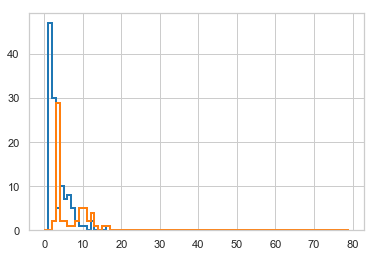

In [46]:
_ = plt.hist(np.diff(chosen_nights), bins=np.arange(0, 80, 1),
            histtype='step', lw=2, normed=0, label='designed')
_ = plt.hist(np.diff(np.sort(baseline_nights)), bins=np.arange(0, 80, 1),
            histtype='step', lw=2, normed=0, label='minion')

In [60]:
np.bincount(np.sort(np.diff(baseline_nights)))

array([ 0,  0,  2, 29,  2,  2,  1,  1,  2,  5,  5,  2,  4,  1,  0,  1,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [59]:
np.bincount(np.sort(np.diff(chosen_nights)))

array([ 0, 47, 30,  5, 10,  7,  8,  5,  2,  1,  1,  0,  2,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

/Users/rbiswas/soft/lsst_stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/rbiswas/soft/lsst_stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/rbiswas/soft/lsst_stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/rbiswas/soft/lsst_stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-pac

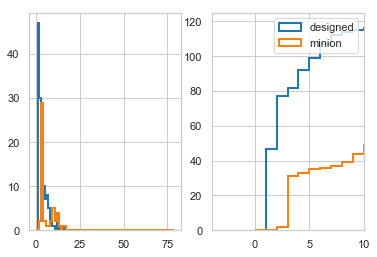

In [44]:
fig, ax = plt.subplots(1, 2)
_ = ax[0].hist(np.diff(chosen_nights), bins=np.arange(0, 80, 1),
            histtype='step', lw=2, normed=0, label='designed')
_ = ax[0].hist(np.diff(np.sort(baseline_nights)), bins=np.arange(0, 80, 1),
            histtype='step', lw=2, normed=0, label='minion')
_ = ax[1].hist(np.diff(chosen_nights), bins=np.arange(0, 80, 1),
            histtype='step', lw=2, cumulative=1, label='designed', normed=0)
_ = ax[1].hist(np.diff(np.sort(baseline_nights)), bins=np.arange(0, 80, 1),
            histtype='step', lw=2, cumulative=1, label='minion', normed=0)

ax[1].set_xlim(xmax=10)
plt.legend(loc='best')
fig.savefig('gap_block2.png')    

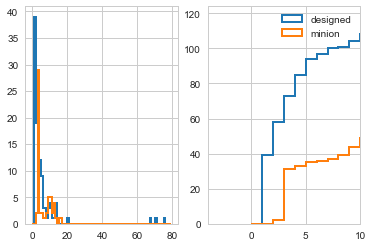

In [78]:
fig, ax = plt.subplots(1, 2)
_ = ax[0].hist(np.diff(chosen_nights), bins=np.arange(0, 80, 1),
            histtype='step', lw=2, normed=0, label='designed')
_ = ax[0].hist(np.diff(np.sort(baseline_nights)), bins=np.arange(0, 80, 1),
            histtype='step', lw=2, normed=0, label='minion')
_ = ax[1].hist(np.diff(chosen_nights), bins=np.arange(0, 80, 1),
            histtype='step', lw=2, cumulative=1, label='designed', normed=0)
_ = ax[1].hist(np.diff(np.sort(baseline_nights)), bins=np.arange(0, 80, 1),
            histtype='step', lw=2, cumulative=1, label='minion', normed=0)

ax[1].set_xlim(xmax=10)
plt.legend(loc='best')
fig.savefig('gap_block2.png')

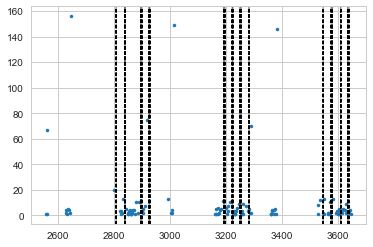

In [50]:
fig, ax = plt.subplots()
ax.plot(chosen_nights[:-1], np.diff(chosen_nights), '.')
for nt in unights:
    ax.axvline(nt, ls='dashed', color='k', lw=1)
#for nt in shortnights:
#    ax.axvline(nt, ls='dashed', color='r', lw=0.1)

## Choosing nights

In [62]:
availabletimes.describe()

,mjd,alt,az,sunAlt,moonRA,moonDec,moonAlt,night,moonDist
count,172579.000000,172579.000000,172579.000000,172579.000000,172579.000000,172579.000000,172579.000000,172579.000000,172579.000000
mean,62753.217276,48.772325,176.398199,-41.414825,154.501634,2.167519,-9.133085,3172.989379,104.259570
std,303.638793,9.322090,139.029425,16.824144,87.403443,16.813126,35.790120,303.654401,42.598460
min,62135.034028,30.001680,0.000751,-79.388402,7.211262,-24.459791,-77.096853,2555.000000,30.000031
25%,62431.047570,40.947493,45.755835,-53.864141,79.735333,-15.971037,-39.795061,2851.000000,67.113953
50%,62752.318752,50.518149,69.998414,-41.406895,151.813425,6.839546,-11.902970,3172.000000,104.608783
75%,63077.439239,57.545609,313.340367,-27.647135,227.101887,18.588453,20.542153,3497.000000,141.610819
max,63229.081254,60.246038,359.999039,-12.000204,313.407143,25.969689,76.744955,3649.000000,173.345992


In [63]:
nstats = op.nightStats(availabletimes)

In [69]:
nstats.head()

,minmjd,maxmjd,availTime
night,,,
2555.0,62135.034028,62135.076389,1.016667
2556.0,62136.034028,62136.073611,0.950000
2557.0,62137.034028,62137.070833,0.883333
2558.0,62138.034028,62138.068056,0.816667
2559.0,62139.034722,62139.065278,0.733333


In [72]:
nstats.loc[chosen_nights].head()

,minmjd,maxmjd,availTime
night,,,
2750,62330.237501,62330.445834,5.000000
2754,62334.226390,62334.445140,5.250000
2761,62341.206945,62341.443056,5.666667
2762,62342.204862,62342.443056,5.716667
2769,62349.185417,62349.440278,6.116667


In [66]:
availabletimes.groupby('night').agg(dict(mjd='count')).describe()

,mjd
count,653.000000
mean,264.286371
std,143.833276
min,1.000000
25%,135.000000
50%,282.000000
75%,409.000000
max,439.000000


In [56]:
availabletimes.groupby('night').agg(dict(mjd='count')).apply(lambda x: x/60.).describe()

,mjd
count,942.000000
mean,4.016207
std,2.193955
min,0.016667
25%,2.187500
50%,4.283333
75%,5.779167
max,7.833333


In [57]:
nstats.loc[chosen_nights]

,minmjd,maxmjd,availTime
night,,,
2559,62139.034722,62139.251389,5.200000
2560,62140.034722,62140.248611,5.133333
2561,62141.034722,62141.245833,5.066667
2628,62208.000000,62208.999306,23.983333
2630,62210.000000,62210.999306,23.983333
2634,62214.000000,62214.999306,23.983333
2635,62215.000000,62215.999306,23.983333
2640,62220.000000,62220.999306,23.983333
2644,62224.000000,62224.999306,23.983333


In [73]:
st_times = op.start_times(nstats, chosen_nights, rng)

In [74]:
st_times

night
2750    62330.262845
2754    62334.285800
2761    62341.224484
2762    62342.231525
2769    62349.374206
2771    62351.299583
2773    62353.352148
2774    62354.305277
2776    62356.236961
2782    62362.318353
2783    62363.269195
2784    62364.317903
2786    62366.178518
2788    62368.300805
2789    62369.235481
2790    62370.308400
2797    62377.299688
2798    62378.206482
2799    62379.336701
2803    62383.143663
2809    62389.078402
2813    62393.298796
2815    62395.133965
2817    62397.096253
2823    62403.044254
2825    62405.146268
2826    62406.233631
2829    62409.114390
2833    62413.163989
2834    62414.016424
            ...     
3507    63087.257281
3509    63089.312829
3511    63091.216558
3514    63094.148184
3516    63096.192805
3518    63098.142492
3524    63104.353770
3528    63108.304794
3534    63114.221452
3535    63115.092348
3540    63120.150118
3542    63122.205379
3547    63127.272321
3548    63128.099445
3555    63135.055034
3561    63141.028525
3564   

In [63]:
v, vl = ObservationPotential.dc2_sequence(st_times.values[0], year_block=2)

/Users/rbiswas/soft/LSST3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:124: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [64]:
dc2_visits = ObservationPotential.dc2_visits(st_times, year_block=1, delta=1)

/Users/rbiswas/soft/LSST3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:124: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [65]:
dc2_visits.head()

,expMJD,filter,night
0,62139.064613,r,2559.0
1,62139.065052,r,2559.0
2,62139.065492,r,2559.0
3,62139.065932,r,2559.0
4,62139.066372,r,2559.0


In [66]:
baseline_block2.expMJD.size

7022

In [67]:
(dc2_visits.expMJD.size + baseline_block2.query('filter == "u"').expMJD.size)

10266

In [68]:
dc2_visits['fieldRA'] = rauDDF
dc2_visits['fieldDec'] = decuDDF

In [69]:
from lsst.sims.photUtils import BandpassDict
import obscond

In [70]:
dc2_visits['FWHMeff'] = 1.0

In [71]:
TotbpDict, hwbpDict = BandpassDict.loadBandpassesFromFiles()
skycalc = obscond.SkyCalculations(photparams="LSST", hwBandpassDict=hwbpDict)

In [72]:
from lsst.sims.skybrightness import SkyModel

In [73]:
synopsim.pointings.iloc[0][['fieldRA', 'fieldDec', 'expMJD']]

fieldRA     0.925184
fieldDec     -0.4789
expMJD       59580.1
Name: 230, dtype: object

In [159]:
sm = SkyModel()

In [163]:
decuDDF

-0.4904375198104066

In [164]:
rauDDF

0.9272061651219876

In [175]:
dc2_visits.iloc[1]

expMJD       61044.1
filter             r
fieldRA     0.927206
fieldDec   -0.490438
FWHMeff            0
Name: 1, dtype: object

In [84]:
#sm.setRaDecMjd(lat=-0.4904, lon=0.927, mjd=61137.5)

In [74]:
dc2_visits.to_csv('dc2_visits_block2')

In [181]:
sm.returnMags(bandpasses=hwbpDict)

{'g': array([22.28796024]),
 'i': array([20.37079804]),
 'r': array([21.28913692]),
 'u': array([22.79937317]),
 'y': array([18.58355142]),
 'z': array([19.3902523])}

In [208]:
dc2_visits.iloc[293]

expMJD       61137.5
filter             r
fieldRA     0.927206
fieldDec   -0.490438
FWHMeff            1
Name: 1, dtype: object

In [102]:
dc2_visits.to_csv('dc2_vists_block1.csv')

In [85]:
skycalc.calculatePointings(dc2_visits.head(293), calcDepths=False)

ValueError: zero-size array to reduction operation maximum which has no identity

In [132]:
from obscond.historicalWeatherData import SeeingFile

In [143]:
seeing = synopsim.pointings[['expMJD', 'rawSeeing']].sort_values(by='expMJD')

In [142]:
from scipy.interpolate import interp1d

In [144]:
rawSeeing = interp1d(seeing.expMJD, seeing.rawSeeing)

In [149]:
seeing.iloc[5:10]['rawSeeing']

obsHistID
235    0.859965
236    0.859965
237    0.859965
238    0.859965
239    0.859965
Name: rawSeeing, dtype: float64

In [145]:
rawSeeing(seeing.expMJD.iloc[5:10])

array([0.859965, 0.859965, 0.859965, 0.859965, 0.859965])

In [140]:
dc2_visits.expMJD.values

array([61044.09996707, 61044.10040689, 61044.1008467 , ...,
       62132.07094641, 62132.07066533, 62132.07038424])

In [116]:
dc2_visits['night'] = np.floor(dc2_visits.expMJD - 59580)

In [117]:
dc2_visits

76

In [282]:
df = availabletimes.groupby('night').agg(dict(mjd=(min, max, timerange))).reset_index()

In [285]:
df.values.shape

(977, 4)

In [286]:
df = pd.DataFrame(df.values, columns=('night', 'minmjd', 'maxmjd', 'timerange'))

In [287]:
df.timediff = (df.maxmjd - df.minmjd)* 24

/Users/rbiswas/soft/LSST3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [289]:
all(df.timerange == df.timediff)

True

## Methods 

In [88]:
def mintime(series):
    return np.remainder(min(series), 1.0) * 24.0

In [ ]:
x = dff.groupby('night').aggregate(dict(alt='count')).reset_index()

## Baseline Expectations

# Scratch

In [ ]:
1480 + 

In [102]:
np.degrees(op.sunAlt_singleTime(61040.0))

4.03231444775151

In [103]:
op.obs

<ephem.Observer date='2025/12/31 00:00:00' epoch='2000/1/1 12:00:00' lon='0:00:00.0' lat='-70:44:57.8' elevation=2650.0m horizon=0:00:00.0 temp=15.0C pressure=1010.0mBar>

In [104]:
op.doff

15019.5

In [107]:
s = ephem.Sun()

In [109]:
op.obs.date = 61040. - op.doff

In [ ]:
sun.compute(lsstObs)
    return sun.alt

In [110]:
s.compute(op.obs)

In [111]:
s.alt

0.0703771635890007

In [140]:
op.sunAlt_singleTime(61040.)

-0.03337714821100235

In [113]:
from lsst.sims.utils import Site

In [114]:
site = Site('LSST')

In [115]:
import ephem

In [116]:
sun = ephem.Sun()

In [117]:
lsstObs = ephem.Observer()
lsstObs.lat = np.radians(site.latitude)
lsstObs.lon = np.radians(site.longitude)
lsstObs.elevation = site.height

In [118]:
lsstObs.date = 61040 - doff

In [120]:
sun.compute(lsstObs)

In [122]:
sun.alt

-0.03337714821100235

In [124]:
lsstObs.lat

-0.527864360290173

In [125]:
op.obs.lat

-1.234809973810476

In [126]:
lsstObs.long

-1.234809973810476

In [127]:
lsstObs.lat

-0.527864360290173

In [265]:
1480 + 59580

61060

In [266]:
opdf.query('night > 1479 and night < 1520')

,alt,az,mjd,moonAlt,moonDec,moonRA,night,sunAlt,moonDist
28800,85.534854,62.409998,61060.000000,6.963303,-18.475540,315.808737,1480,-1.996018,87.551695
28801,85.725500,60.939025,61060.000695,6.765085,-18.471209,315.817644,1480,-2.132110,87.546388
28802,85.913325,59.337531,61060.001389,6.567147,-18.466878,315.826565,1480,-2.272920,87.541067
28803,86.097920,57.589058,61060.002083,6.369501,-18.462548,315.835501,1480,-2.421856,87.535734
28804,86.278806,55.674881,61060.002778,6.172159,-18.458218,315.844452,1480,-2.584568,87.530388
28805,86.455411,53.573817,61060.003472,5.975133,-18.453888,315.853418,1480,-2.771692,87.525029
28806,86.627064,51.262103,61060.004167,5.778438,-18.449559,315.862399,1480,-3.007011,87.519656
28807,86.792968,48.713439,61060.004861,5.582089,-18.445230,315.871395,1480,-3.358057,87.514271
28808,86.952183,45.899308,61060.005556,5.386101,-18.440902,315.880405,1480,-3.918340,87.508872
28809,87.103606,42.789730,61060.006250,5.190495,-18.436574,315.889431,1480,-4.401330,87.503460


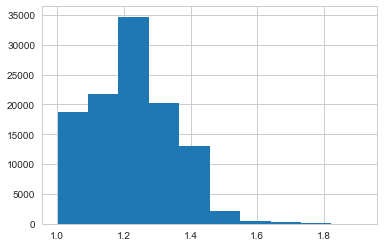

In [211]:
synopsim.pointings.airmass.hist()